# Model Evaluation / Comparison

In [1]:
import torch
from tools import plot_column_from_csv, load_model, torcherize_batch, get_data_loader
from tokenizer import get_tokenizer

In [2]:
models_to_compare = [
    'tall_and_skinny',
    '5foot11_and_skinnyfat',
    'short_and_thick'
]

### first up we'll look at loss curves
notice that even with a log scale I had to splice out the first 10% to make the lines distinct

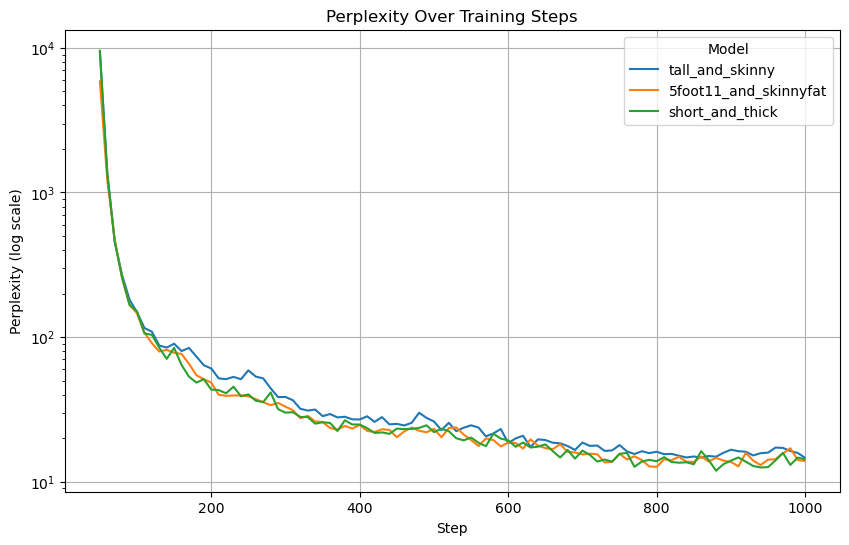

In [3]:
plot_column_from_csv(models_to_compare, 'Step', 'Perplexity', log_y=True, trim_percentage=5)

### now let's compare individual token accuracies

In [14]:
batch_size = 1 # can only be 1 until i fix batched inference
topk = 5

In [36]:
# Data preparation
data_loader = get_data_loader(batch_size=batch_size, split='validation')
text = next(iter(data_loader))
tokenizer = get_tokenizer(2048)
x, y = torcherize_batch(tokenizer, text)  # x and y are tensors shape [batch_size, 512] of dtype torch.int64

print(text[0])
# we want to make sure to choose a y value that takes advantage of the full context for the best estimate,
# so avoid stories that are too short and have padding tokens at teh end
print(y)

Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


['Tom and Anna like to play with their cars. They have many cars of different colors and sizes. Some cars are old and some cars are modern. Modern cars are shiny and fast.\nOne day, Tom and Anna decide to have a race with their cars. They make a track with their blocks and books. They choose their cars and get ready to start. Tom picks a modern car that is red and silver. Anna picks an old car that is blue and yellow.\n"Ready, set, go!" Tom says and pushes his car. Anna pushes her car too. The cars zoom along the track, passing the blocks and books. Tom\'s car is faster than Anna\'s car. He thinks he will win the race.\nBut then, something happens. Tom\'s car hits a book and flips over. It lands on its roof and stops. Anna\'s car keeps going and reaches the end of the track. Anna jumps up and cheers.\n"I win! I win!" Anna says. "My car is the best!"\nTom feels sad and angry. He picks up his car and wipes the dust off it. He looks at Anna and says, "No, you don\'t win. You cheat! You pu

In [37]:
# Function to calculate top-k accuracy
def calculate_topk_accuracy(logits, targets, k=5):
    topk_indices = torch.topk(logits, k, dim=2).indices
    correct = topk_indices.eq(targets.unsqueeze(2).expand_as(topk_indices))
    return correct.any(dim=2).float().mean()

In [38]:
# Evaluate models
results = {}
for model_name in models_to_compare:
    model, _, _ = load_model(model_name)
    model.eval()
    with torch.no_grad():
        logits, _ = model(x)
    
    topk_accuracy = calculate_topk_accuracy(logits, y, k=topk)
    topk_values, topk_indices = torch.topk(logits, topk, dim=2)
    
    # Store results
    results[model_name] = {
        'accuracy': topk_accuracy.item(),
        'topk_indices': topk_indices,
        'topk_values': topk_values
    }

ModelConfig(dim=64, vocab_len=2051, device='cpu', num_layers=10, second_resid_norm=False, mlp_hidden_mult=1, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=10, num_kv_heads=2, head_dim=16, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 502.592 K parameters
ModelConfig(dim=64, vocab_len=2051, device='cpu', num_layers=8, second_resid_norm=False, mlp_hidden_mult=2, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=8, num_kv_heads=2, head_dim=16, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 493.888 K parameters
ModelConfig(dim=64, vocab_len=2051, device='cpu', num_layers=4, second_resid_norm=False, mlp_hidden_mult=4, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=16, num_kv_heads=4, head_dim=16, theta=10000, max_seq_len=512, scale_first_resi

In [49]:
# Define a function to format the model output
def format_model_output(model_name, data, topk):
    print(f"Model: {model_name}")
    print(f"  - Top-{topk} Accuracy: {data['accuracy']*100:.2f}%")
    
    # Fetch the top-k predictions for the last token and decode each token
    top_predictions = data['topk_indices'][:,-1,:].squeeze(0).tolist()
    print("  - Top predictions for the last token:")
    for token_index in top_predictions:
        decoded_token = tokenizer.decode([token_index])
        print(f"    - Index: {token_index}, Token: {decoded_token}")
    print()

# Display the results for each model
for name, data in results.items():
    format_model_output(name, data, topk)

# Show the correct value and its decoded form
correct_value = y[:,-1].tolist()
decoded_correct_value = tokenizer.decode(correct_value)
print(f"Correct value: {correct_value[0]} = {decoded_correct_value}")

Model: tall_and_skinny
  - Top-5 Accuracy: 53.12%
  - Top predictions for the last token:
    - Index: 677, Token: and
    - Index: 144, Token: the
    - Index: 174, Token: said
    - Index: 893, Token: that
    - Index: 83, Token: s

Model: 5foot11_and_skinnyfat
  - Top-5 Accuracy: 55.27%
  - Top predictions for the last token:
    - Index: 677, Token: and
    - Index: 174, Token: said
    - Index: 1117, Token: was
    - Index: 893, Token: that
    - Index: 144, Token: the

Model: short_and_thick
  - Top-5 Accuracy: 54.69%
  - Top predictions for the last token:
    - Index: 677, Token: and
    - Index: 144, Token: the
    - Index: 893, Token: that
    - Index: 174, Token: said
    - Index: 1117, Token: was

Correct value: 677 = and


# in the future it'd be cool to build out an automated GPT-4 rater like what they used in the TinyStories paper